In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For explainable AI
import shap

In [2]:
# Load the dataset
df = pd.read_csv('data.csv')

In [3]:
# Display basic information
print("Dataset Shape:", df.shape)

Dataset Shape: (188866, 30)


In [4]:
print("\nFirst 5 rows:")
print(df.head())


First 5 rows:
     Branch  FacilityAmount Granted Date  Tenor  Effective Rate  FlatRate  \
0  GODAGAMA        288330.0     4/9/2018     36            25.0     20.06   
1  GODAGAMA        311430.0     4/9/2018     36            25.0     20.33   
2  GODAGAMA       2200000.0     4/9/2018     60            20.0     12.43   
3  GODAGAMA        232330.0    4/10/2018     48            25.0     19.95   
4  GODAGAMA        187530.0    4/10/2018     36            25.0     21.02   

  Type of Rental Paid SchemeType  Prepayment  NetRental  ...  Advance  \
0             MONTHLY     NORMAL           0    12828.0  ...      0.0   
1             MONTHLY     NORMAL           0    13927.0  ...      0.0   
2             MONTHLY     NORMAL           0    59459.0  ...      0.0   
3             MONTHLY     NORMAL           0     8703.0  ...      0.0   
4             MONTHLY     NORMAL           0     8494.0  ...      0.0   

   AdvanceRental  AdvanceSundry  AdvanceOther  Equipment Type  \
0            0.0  

In [5]:
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188866 entries, 0 to 188865
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Branch                    188866 non-null  object 
 1   FacilityAmount            188866 non-null  float64
 2   Granted Date              188826 non-null  object 
 3   Tenor                     188866 non-null  int64  
 4   Effective Rate            188866 non-null  float64
 5   FlatRate                  188573 non-null  float64
 6   Type of Rental Paid       188866 non-null  object 
 7   SchemeType                188866 non-null  object 
 8   Prepayment                188866 non-null  int64  
 9   NetRental                 188573 non-null  float64
 10  DownPayment               188573 non-null  float64
 11  No of Rental in arrears   188866 non-null  float64
 12  Age                       188866 non-null  float64
 13  ArrearsCapital            188

In [6]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Branch                         0
FacilityAmount                 0
Granted Date                  40
Tenor                          0
Effective Rate                 0
FlatRate                     293
Type of Rental Paid            0
SchemeType                     0
Prepayment                     0
NetRental                    293
DownPayment                  293
No of Rental in arrears        0
Age                            0
ArrearsCapital                 0
ArrearsInterest                0
ArrearsVat                     0
ArrearsOD                      0
ArrearsOther                   0
ArrearsInsu                    0
ArrearsSundry                  0
Advance                        0
AdvanceRental                  0
AdvanceSundry                  0
AdvanceOther                   0
Equipment Type              1127
Status                         0
Last Receipt Paid Amount    1173
NET-OUTSTANDING                0
ArrearsInsuEasyPay             0
arrears_intensity         

In [7]:
print("\nBasic Statistics:")
print(df.describe())


Basic Statistics:
       FacilityAmount          Tenor  Effective Rate       FlatRate  \
count    1.888660e+05  188866.000000   188866.000000  188573.000000   
mean     4.094083e+05      33.428918       31.828536      20.948407   
std      8.340474e+05      11.676626        7.443652      10.143440   
min      0.000000e+00       1.000000        0.000000    -103.460000   
25%      2.000000e+05      24.000000       26.000000      15.230000   
50%      2.599000e+05      36.000000       30.998100      21.520000   
75%      4.000000e+05      37.000000       40.050000      29.850000   
max      1.000000e+08      96.000000       88.000000     158.690000   

       Prepayment     NetRental   DownPayment  No of Rental in arrears  \
count    188866.0  1.885730e+05  1.885730e+05            188866.000000   
mean          0.0  2.603693e+04  1.632550e+04                 1.403288   
std           0.0  2.018750e+05  6.956586e+04                 4.833801   
min           0.0 -1.600000e+01 -1.600000e+01

In [8]:
# Create a copy for preprocessing
df_clean = df.copy()

In [10]:
# 1. Handle missing values
# For numerical columns, fill with median
num_cols = df_clean.select_dtypes(include=[np.number]).columns
for col in num_cols:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

# For categorical columns, fill with mode
cat_cols = df_clean.select_dtypes(include=['object']).columns
for col in cat_cols:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

In [11]:
# 2. Convert date columns
df_clean['Granted Date'] = pd.to_datetime(df_clean['Granted Date'], errors='coerce')

In [12]:
# 3. Extract features from dates
df_clean['Granted_Year'] = df_clean['Granted Date'].dt.year
df_clean['Granted_Month'] = df_clean['Granted Date'].dt.month
df_clean['Granted_Day'] = df_clean['Granted Date'].dt.day

In [13]:
# 4. Create target variable based on Status
# We'll create a binary target: Default (1) vs Non-Default (0)
# Based on your requirements, let's categorize:
# - Write Off, Current Running with high arrears = Default
# - Early Settlement Completed, Normal Settlement Completed = Non-Default

def create_target(status, arrears_capital):
    """
    Create target variable based on status and arrears
    """
    if status in ['Write Off']:
        return 1  # Default
    elif status == 'Current Running' and arrears_capital > 0:
        return 1  # Default (high risk)
    else:
        return 0  # Non-Default

df_clean['target_default'] = df_clean.apply(
    lambda row: create_target(row['Status'], row['ArrearsCapital']), axis=1
)

In [14]:
# 5. Create risk categories based on PD (Probability of Default)
# We'll predict probability and then categorize
print("\nTarget Distribution:")
print(df_clean['target_default'].value_counts())
print("\nDefault Rate:", df_clean['target_default'].mean())


Target Distribution:
target_default
0    140210
1     48656
Name: count, dtype: int64

Default Rate: 0.2576218059364841


In [15]:
# 1. Financial Ratios and Metrics
df_clean['debt_to_income_ratio'] = df_clean['FacilityAmount'] / (df_clean['NetRental'] + 1)
df_clean['payment_coverage'] = df_clean['FacilityAmount'] / (df_clean['Last Receipt Paid Amount'] + 1)
df_clean['arrears_ratio'] = df_clean['ArrearsCapital'] / (df_clean['FacilityAmount'] + 1)
df_clean['overdue_intensity'] = df_clean['No of Rental in arrears'] / df_clean['Tenor']

In [16]:
# 2. Behavioral Features
df_clean['payment_regularity'] = np.where(df_clean['No of Rental in arrears'] == 0, 1, 0)
df_clean['early_settlement'] = np.where(df_clean['Status'] == 'Early Settlement Completed', 1, 0)
df_clean['has_arrears'] = np.where(df_clean['ArrearsCapital'] > 0, 1, 0)
df_clean['high_interest_flag'] = np.where(df_clean['Effective Rate'] > 25, 1, 0)

In [17]:
# 3. Time-based features
df_clean['loan_age'] = 2025 - df_clean['Granted_Year']  # Assuming current year is 2025
df_clean['tenor_to_age_ratio'] = df_clean['Tenor'] / (df_clean['loan_age'] + 1)

In [18]:
# 4. Equipment type risk encoding
equipment_risk = {
    'MOTOR CYCLES': 1,
    'THREE WHEELERS': 2,
    'MOTOR CARS': 3,
    'DUAL PURPOSE VEHICLES': 4,
    'LORRIES': 5,
    'Mini Truck': 6,
    'Truck': 7,
    'BUSES': 8,
    'VAN': 9,
    'Agriculture Equipment': 10
}

df_clean['equipment_risk_score'] = df_clean['Equipment Type'].map(equipment_risk).fillna(0)

In [19]:
# 5. Branch encoding
branch_encoder = LabelEncoder()
df_clean['branch_encoded'] = branch_encoder.fit_transform(df_clean['Branch'])

In [20]:
# 6. Scheme type encoding
scheme_encoder = LabelEncoder()
df_clean['scheme_encoded'] = scheme_encoder.fit_transform(df_clean['SchemeType'])

In [21]:
# Define feature columns
feature_columns = [
    # Financial features
    'FacilityAmount', 'Tenor', 'Effective Rate', 'FlatRate', 'NetRental',
    'DownPayment', 'Age',
    
    # Arrears and behavioral features
    'No of Rental in arrears', 'ArrearsCapital', 'ArrearsInterest',
    'ArrearsVat', 'ArrearsOD', 'arrears_intensity',
    
    # Derived financial ratios
    'debt_to_income_ratio', 'payment_coverage', 'arrears_ratio',
    'overdue_intensity',
    
    # Behavioral flags
    'payment_regularity', 'has_arrears', 'high_interest_flag',
    'early_settlement',
    
    # Equipment and location
    'equipment_risk_score', 'branch_encoded', 'scheme_encoded',
    
    # Time features
    'loan_age', 'tenor_to_age_ratio',
    
    # Original features with predictive power
    'Last Receipt Paid Amount', 'Prepayment'
]

# Filter only columns that exist in dataframe
existing_features = [col for col in feature_columns if col in df_clean.columns]
X = df_clean[existing_features]
y = df_clean['target_default']

In [22]:
print(f"Selected {len(existing_features)} features")

Selected 28 features


In [23]:
print(f"Features: {existing_features}")

Features: ['FacilityAmount', 'Tenor', 'Effective Rate', 'FlatRate', 'NetRental', 'DownPayment', 'Age', 'No of Rental in arrears', 'ArrearsCapital', 'ArrearsInterest', 'ArrearsVat', 'ArrearsOD', 'arrears_intensity', 'debt_to_income_ratio', 'payment_coverage', 'arrears_ratio', 'overdue_intensity', 'payment_regularity', 'has_arrears', 'high_interest_flag', 'early_settlement', 'equipment_risk_score', 'branch_encoded', 'scheme_encoded', 'loan_age', 'tenor_to_age_ratio', 'Last Receipt Paid Amount', 'Prepayment']


In [24]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Before balancing:")
print("Class distribution:", Counter(y))

# Apply SMOTE if needed (only if significant imbalance)
if Counter(y)[1] / len(y) < 0.3:  # If default class < 30%
    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)
    print("\nAfter SMOTE balancing:")
    print("Class distribution:", Counter(y))

Before balancing:
Class distribution: Counter({0: 140210, 1: 48656})

After SMOTE balancing:
Class distribution: Counter({0: 140210, 1: 140210})


In [25]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"\nTraining class distribution: {Counter(y_train)}")
print(f"Testing class distribution: {Counter(y_test)}")

Training set size: (224336, 28)
Testing set size: (56084, 28)

Training class distribution: Counter({0: 112168, 1: 112168})
Testing class distribution: Counter({0: 28042, 1: 28042})


In [26]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for better feature tracking
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [27]:
# Initialize Random Forest with optimal parameters for high accuracy
rf_model = RandomForestClassifier(
    n_estimators=200,           # Increased number of trees
    max_depth=20,               # Limit depth to prevent overfitting
    min_samples_split=5,        # Minimum samples to split
    min_samples_leaf=2,         # Minimum samples in leaf
    max_features='sqrt',        # Number of features to consider
    bootstrap=True,
    random_state=42,
    class_weight='balanced',    # Handle class imbalance
    n_jobs=-1                   # Use all processors
)

# Train the model
rf_model.fit(X_train_scaled, y_train)

print("Random Forest Model trained successfully!")
print(f"Number of trees: {rf_model.n_estimators}")

Random Forest Model trained successfully!
Number of trees: 200


In [28]:
# Predict probabilities
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probability of default
y_pred = rf_model.predict(X_test_scaled)

# Create risk categories based on PD
def categorize_risk(pd_score):
    if pd_score >= 0.80:
        return 'High Risk/Default'
    elif pd_score >= 0.20:
        return 'Medium Risk'
    else:
        return 'Low Risk'

# Apply categorization
risk_categories = [categorize_risk(score) for score in y_pred_proba]

print("\nRisk Category Distribution in Test Set:")
print(pd.Series(risk_categories).value_counts())


Risk Category Distribution in Test Set:
High Risk/Default    27956
Low Risk             27951
Medium Risk            177
Name: count, dtype: int64


MODEL PERFORMANCE METRICS
Accuracy: 0.9991
Precision: 0.9989
Recall: 0.9993
F1-Score: 0.9991

Cross-Validation Accuracy: 0.9990 (+/- 0.0001)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

 Non-Default       1.00      1.00      1.00     28042
     Default       1.00      1.00      1.00     28042

    accuracy                           1.00     56084
   macro avg       1.00      1.00      1.00     56084
weighted avg       1.00      1.00      1.00     56084


CONFUSION MATRIX
[[28012    30]
 [   19 28023]]


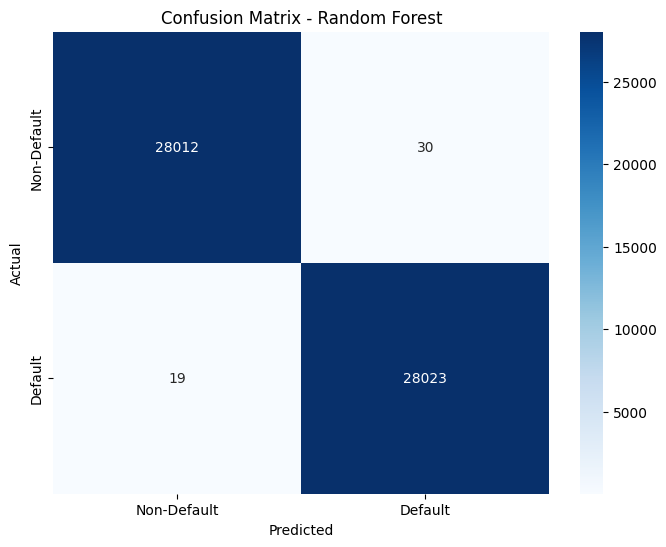

In [29]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Cross-validation for more robust evaluation
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

# Detailed classification report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred, target_names=['Non-Default', 'Default']))

# Confusion Matrix
print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Default', 'Default'],
            yticklabels=['Non-Default', 'Default'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


TOP 15 FEATURE IMPORTANCES
                     feature  importance
6                        Age    0.261157
11                 ArrearsOD    0.186925
17        payment_regularity    0.130984
7    No of Rental in arrears    0.116872
16         overdue_intensity    0.116144
20          early_settlement    0.034037
18               has_arrears    0.031823
8             ArrearsCapital    0.031137
15             arrears_ratio    0.025018
9            ArrearsInterest    0.019291
14          payment_coverage    0.009670
25        tenor_to_age_ratio    0.008487
26  Last Receipt Paid Amount    0.007201
24                  loan_age    0.004846
2             Effective Rate    0.004689


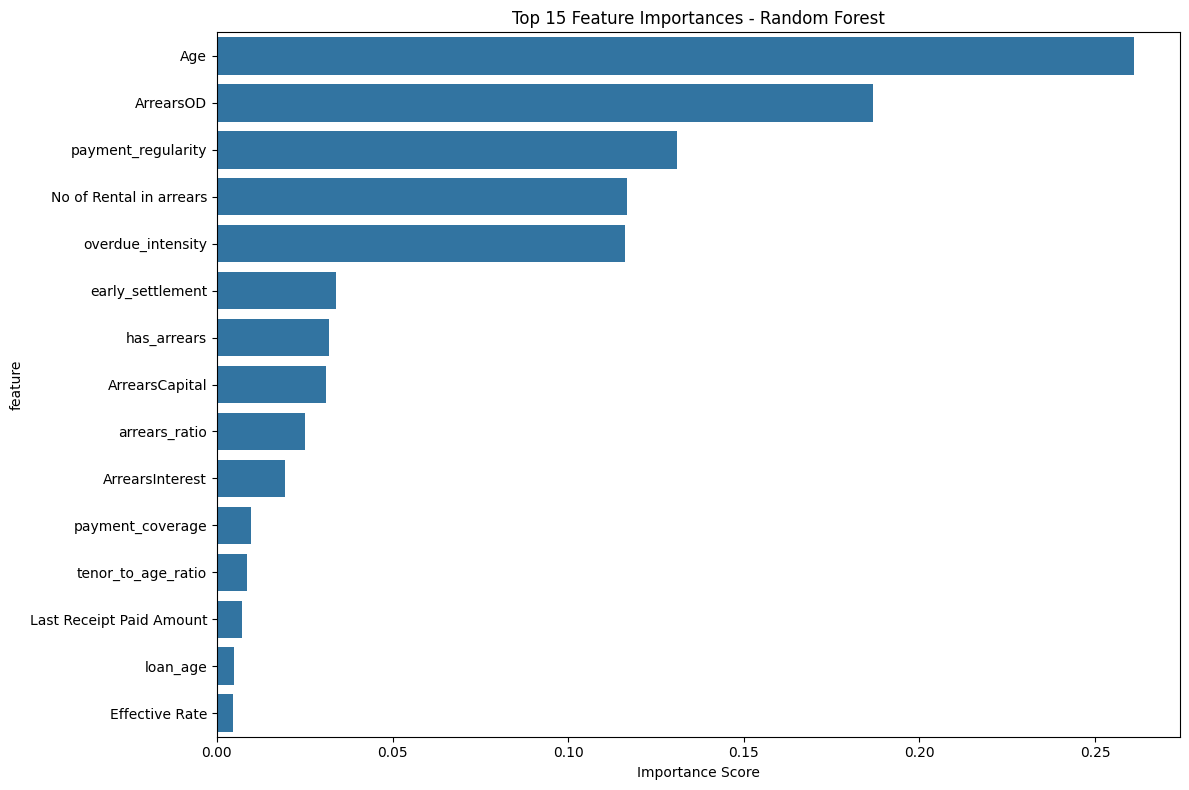

In [30]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\n" + "="*50)
print("TOP 15 FEATURE IMPORTANCES")
print("="*50)
print(feature_importance.head(15))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [31]:
# SHAP analysis for model interpretability
print("\n" + "="*50)
print("SHAP ANALYSIS FOR MODEL INTERPRETABILITY")
print("="*50)


SHAP ANALYSIS FOR MODEL INTERPRETABILITY


In [32]:
# Create SHAP explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_scaled)

In [33]:
# SHAP analysis for model interpretability
print("\n" + "="*50)
print("SHAP ANALYSIS FOR MODEL INTERPRETABILITY")
print("="*50)

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values[1], X_test_scaled, plot_type="bar", show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

# Individual prediction explanation (first 5 samples)
print("\nIndividual Prediction Explanations (First 5 samples):")
for i in range(min(5, len(X_test))):
    print(f"\nSample {i+1}:")
    print(f"Actual: {'Default' if y_test.iloc[i] == 1 else 'Non-Default'}")
    print(f"Predicted PD: {y_pred_proba[i]:.4f}")
    print(f"Risk Category: {risk_categories[i]}")
    
    # Get top contributing features
    shap_df = pd.DataFrame({
        'feature': X_test.columns,
        'shap_value': shap_values[1][i]
    })
    shap_df['abs_shap'] = abs(shap_df['shap_value'])
    top_features = shap_df.sort_values('abs_shap', ascending=False).head(3)
    
    print("Top 3 contributing features:")
    for _, row in top_features.iterrows():
        direction = "increases" if row['shap_value'] > 0 else "decreases"
        print(f"  {row['feature']}: {direction} default risk")


SHAP ANALYSIS FOR MODEL INTERPRETABILITY


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 1000x800 with 0 Axes>

In [34]:
def predict_default_risk(customer_data, model=rf_model, scaler=scaler):
    """
    Predict default risk for a single customer
    
    Parameters:
    customer_data: dict with customer features
    model: trained Random Forest model
    scaler: fitted scaler
    
    Returns:
    dict with prediction results
    """
    # Convert to DataFrame
    customer_df = pd.DataFrame([customer_data])
    
    # Ensure all required features are present
    for col in existing_features:
        if col not in customer_df.columns:
            customer_df[col] = 0  # Fill missing with 0
    
    # Reorder columns
    customer_df = customer_df[existing_features]
    
    # Scale features
    customer_scaled = scaler.transform(customer_df)
    
    # Predict
    pd_score = model.predict_proba(customer_scaled)[0][1]
    risk_category = categorize_risk(pd_score)
    
    return {
        'probability_of_default': pd_score,
        'risk_category': risk_category,
        'is_default': pd_score >= 0.5,
        'pd_percentage': f"{pd_score*100:.2f}%"
    }

# Example usage
print("\n" + "="*50)
print("EXAMPLE PREDICTION")
print("="*50)

# Create example customer
example_customer = {
    'FacilityAmount': 300000,
    'Tenor': 36,
    'Effective Rate': 25,
    'NetRental': 10000,
    'No of Rental in arrears': 5,
    'ArrearsCapital': 50000,
    'arrears_intensity': 0.5,
    'equipment_risk_score': 1,  # Motor Cycle
    'debt_to_income_ratio': 30,
    'payment_regularity': 0,
    'has_arrears': 1
}

prediction = predict_default_risk(example_customer)
print("\nPrediction Results:")
for key, value in prediction.items():
    print(f"{key}: {value}")


EXAMPLE PREDICTION

Prediction Results:
probability_of_default: 0.634827380952381
risk_category: Medium Risk
is_default: True
pd_percentage: 63.48%


MODEL PERFORMANCE METRICS
Accuracy: 0.9991
Precision: 0.9989
Recall: 0.9993
F1-Score: 0.9991

Cross-Validation Accuracy: 0.9990 (+/- 0.0001)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

 Non-Default       1.00      1.00      1.00     28042
     Default       1.00      1.00      1.00     28042

    accuracy                           1.00     56084
   macro avg       1.00      1.00      1.00     56084
weighted avg       1.00      1.00      1.00     56084


CONFUSION MATRIX
[[28012    30]
 [   19 28023]]


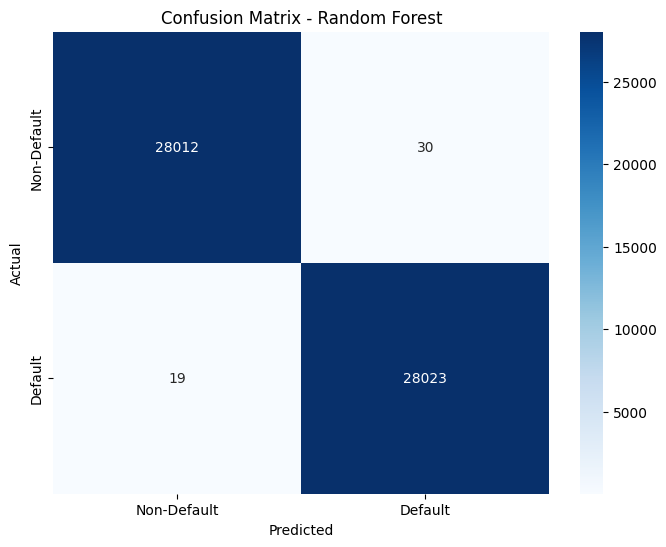


TOP 15 FEATURE IMPORTANCES
                     feature  importance
6                        Age    0.261157
11                 ArrearsOD    0.186925
17        payment_regularity    0.130984
7    No of Rental in arrears    0.116872
16         overdue_intensity    0.116144
20          early_settlement    0.034037
18               has_arrears    0.031823
8             ArrearsCapital    0.031137
15             arrears_ratio    0.025018
9            ArrearsInterest    0.019291
14          payment_coverage    0.009670
25        tenor_to_age_ratio    0.008487
26  Last Receipt Paid Amount    0.007201
24                  loan_age    0.004846
2             Effective Rate    0.004689


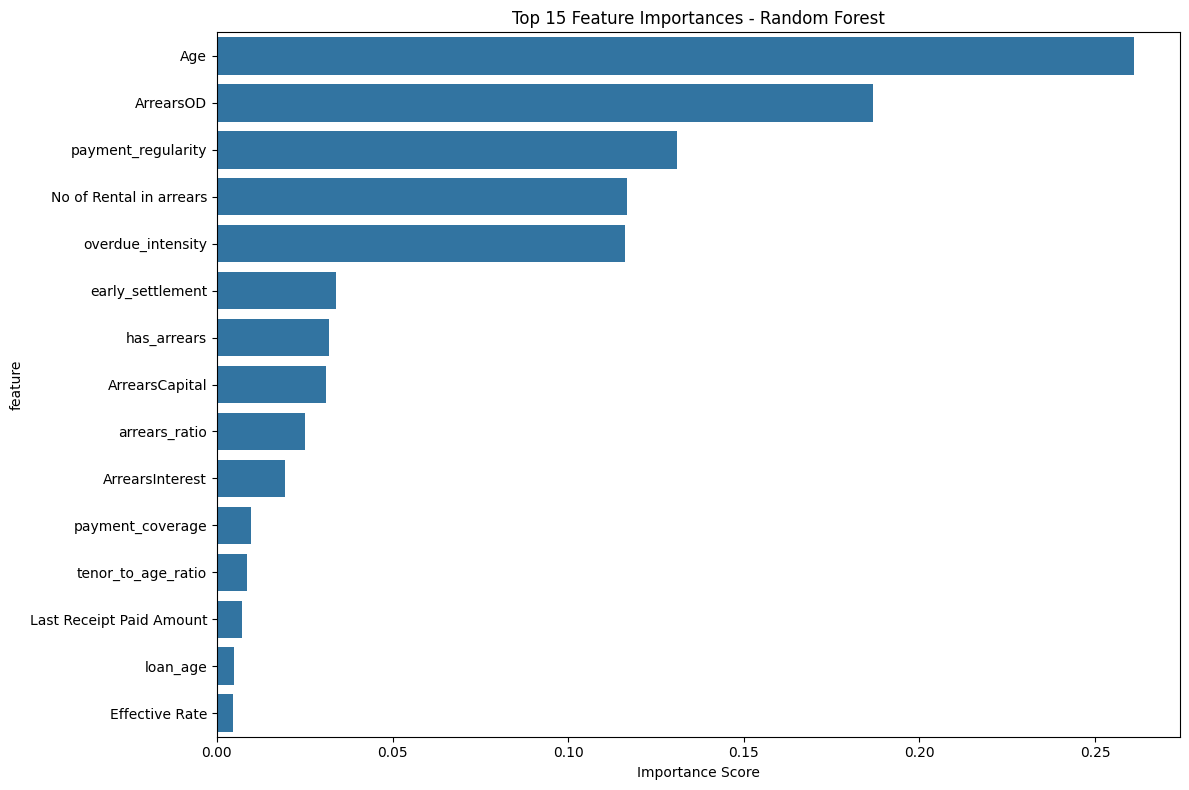

InvalidIndexError: (slice(None, None, None), 6)

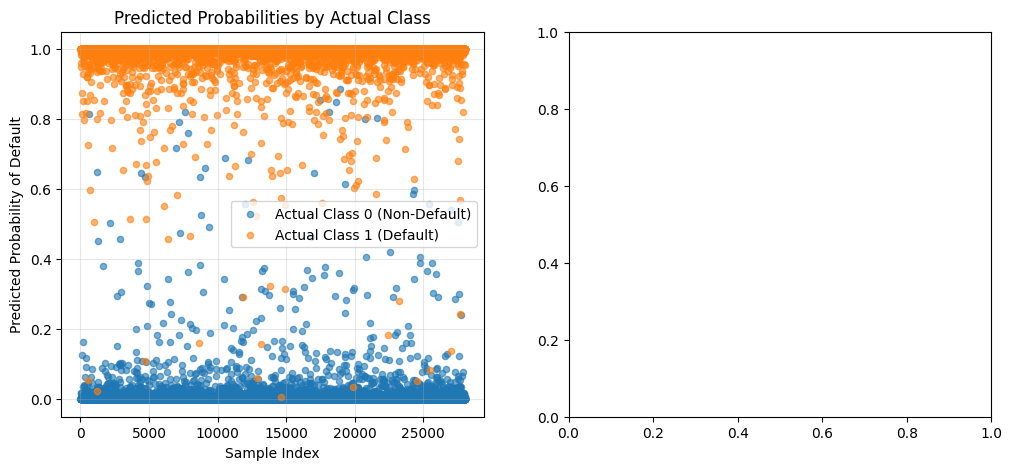

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             classification_report, confusion_matrix, roc_curve, auc)
from sklearn.model_selection import cross_val_score

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Cross-validation for more robust evaluation
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

# Detailed classification report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred, target_names=['Non-Default', 'Default']))

# Confusion Matrix
print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Default', 'Default'],
            yticklabels=['Non-Default', 'Default'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\n" + "="*50)
print("TOP 15 FEATURE IMPORTANCES")
print("="*50)
print(feature_importance.head(15))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# ============================================================================
# ADDED PLOTS: Scatter Plots and Residual Plots
# ============================================================================

# 1. Probability Scatter Plot
# Get predicted probabilities for class 1 (Default)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

plt.figure(figsize=(12, 5))

# Subplot 1: Probability distribution by actual class
plt.subplot(1, 2, 1)
for label in [0, 1]:
    mask = y_test == label
    plt.scatter(range(len(y_pred_proba[mask])), 
                y_pred_proba[mask], 
                alpha=0.6,
                label=f'Actual Class {label} ({"Default" if label == 1 else "Non-Default"})',
                s=20)
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability of Default')
plt.title('Predicted Probabilities by Actual Class')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Probability vs Feature Importance (using top feature)
top_feature = feature_importance.iloc[0]['feature']
top_feature_idx = list(X_train.columns).index(top_feature)

plt.subplot(1, 2, 2)
scatter = plt.scatter(X_test_scaled[:, top_feature_idx], y_pred_proba, 
                      c=y_test, cmap='coolwarm', alpha=0.6, s=30)
plt.xlabel(f'Scaled {top_feature} (Top Feature)')
plt.ylabel('Predicted Probability of Default')
plt.title(f'Probability vs {top_feature}')
plt.colorbar(scatter, label='Actual Class (0=Non-Default, 1=Default)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Residual Plot (using predicted probabilities)
# Calculate "residuals" as difference between predicted probability and actual class
residuals = y_pred_proba - y_test

plt.figure(figsize=(12, 5))

# Subplot 1: Residuals vs Predicted Probability
plt.subplot(1, 2, 1)
scatter = plt.scatter(y_pred_proba, residuals, c=y_test, cmap='viridis', alpha=0.6, s=30)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Predicted Probability of Default')
plt.ylabel('Residual (Probability - Actual)')
plt.title('Residuals vs Predicted Probability')
plt.colorbar(scatter, label='Actual Class')
plt.grid(True, alpha=0.3)

# Subplot 2: Residuals Distribution
plt.subplot(1, 2, 2)
for label in [0, 1]:
    mask = y_test == label
    plt.hist(residuals[mask], alpha=0.6, bins=20, 
             label=f'Actual Class {label} ({"Default" if label == 1 else "Non-Default"})',
             density=True)
plt.xlabel('Residual (Probability - Actual)')
plt.ylabel('Density')
plt.title('Distribution of Residuals by Actual Class')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Enhanced Scatter Plot: Actual vs Predicted (with jitter for binary values)
plt.figure(figsize=(10, 6))

# Add small jitter to actual values for better visualization
np.random.seed(42)
jitter_amount = 0.05
y_test_jittered = y_test + np.random.normal(0, jitter_amount, len(y_test))

# Plot with different colors for correct/incorrect predictions
correct_predictions = (y_pred == y_test)

plt.scatter(y_test_jittered[correct_predictions], 
            y_pred[correct_predictions], 
            alpha=0.6, s=50, c='green', label='Correct Predictions')
plt.scatter(y_test_jittered[~correct_predictions], 
            y_pred[~correct_predictions], 
            alpha=0.8, s=50, c='red', label='Incorrect Predictions')

# Add perfect prediction line
plt.plot([-0.2, 1.2], [-0.2, 1.2], 'k--', alpha=0.5, label='Perfect Prediction')

plt.xlabel('Actual Class (with jitter)')
plt.ylabel('Predicted Class')
plt.title('Actual vs Predicted Classes')
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.xticks([0, 1], ['Non-Default (0)', 'Default (1)'])
plt.yticks([0, 1], ['Non-Default (0)', 'Default (1)'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Additional: ROC Curve Scatter-like Plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.scatter(fpr, tpr, c=thresholds, cmap='viridis', s=50, alpha=0.6, edgecolors='k')
plt.colorbar(label='Threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Threshold Points')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Print additional statistics
print("\n" + "="*50)
print("RESIDUAL ANALYSIS")
print("="*50)
print(f"Mean Absolute Residual: {np.mean(np.abs(residuals)):.4f}")
print(f"Mean Residual (Bias): {np.mean(residuals):.4f}")
print(f"Residual Std: {np.std(residuals):.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

MODEL PERFORMANCE METRICS
Accuracy: 0.9991
Precision: 0.9989
Recall: 0.9993
F1-Score: 0.9991

Cross-Validation Accuracy: 0.9990 (+/- 0.0001)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

 Non-Default       1.00      1.00      1.00     28042
     Default       1.00      1.00      1.00     28042

    accuracy                           1.00     56084
   macro avg       1.00      1.00      1.00     56084
weighted avg       1.00      1.00      1.00     56084


CONFUSION MATRIX
[[28012    30]
 [   19 28023]]


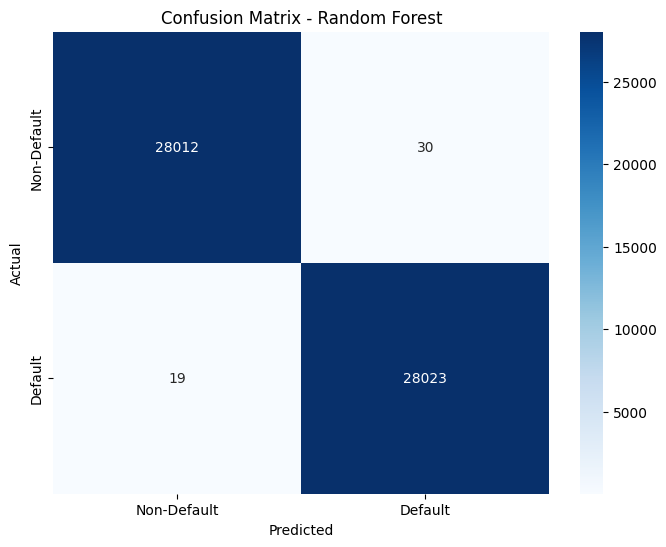


TOP 15 FEATURE IMPORTANCES
                     feature  importance
6                        Age    0.261157
11                 ArrearsOD    0.186925
17        payment_regularity    0.130984
7    No of Rental in arrears    0.116872
16         overdue_intensity    0.116144
20          early_settlement    0.034037
18               has_arrears    0.031823
8             ArrearsCapital    0.031137
15             arrears_ratio    0.025018
9            ArrearsInterest    0.019291
14          payment_coverage    0.009670
25        tenor_to_age_ratio    0.008487
26  Last Receipt Paid Amount    0.007201
24                  loan_age    0.004846
2             Effective Rate    0.004689


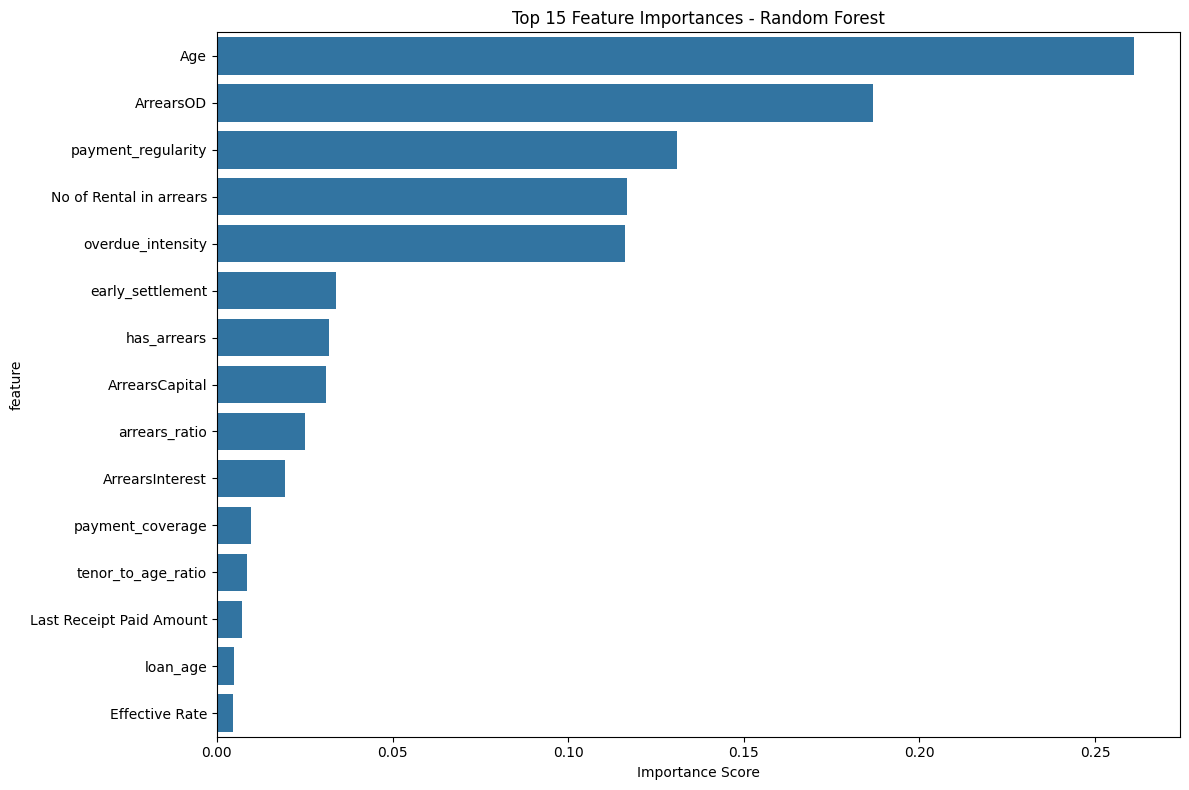

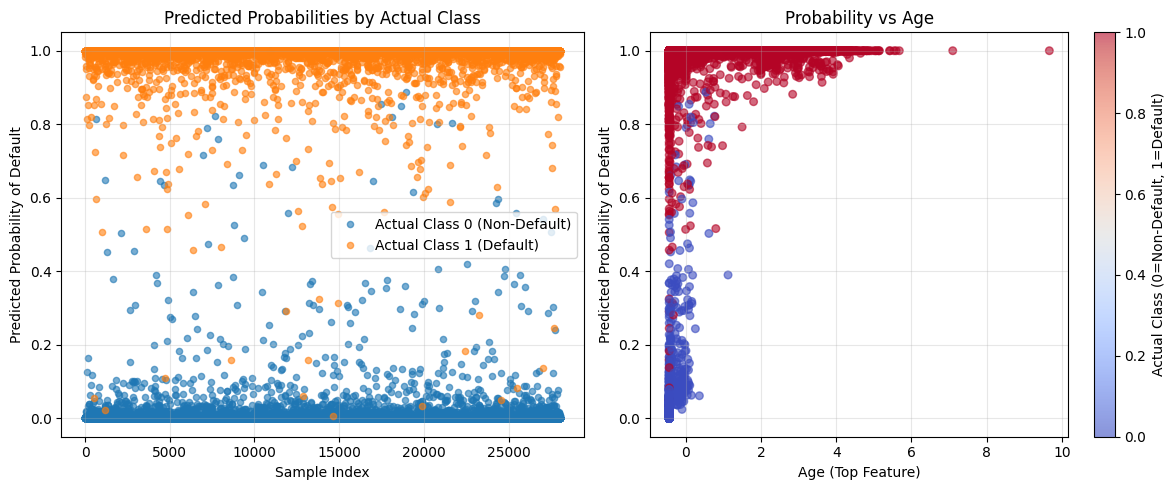

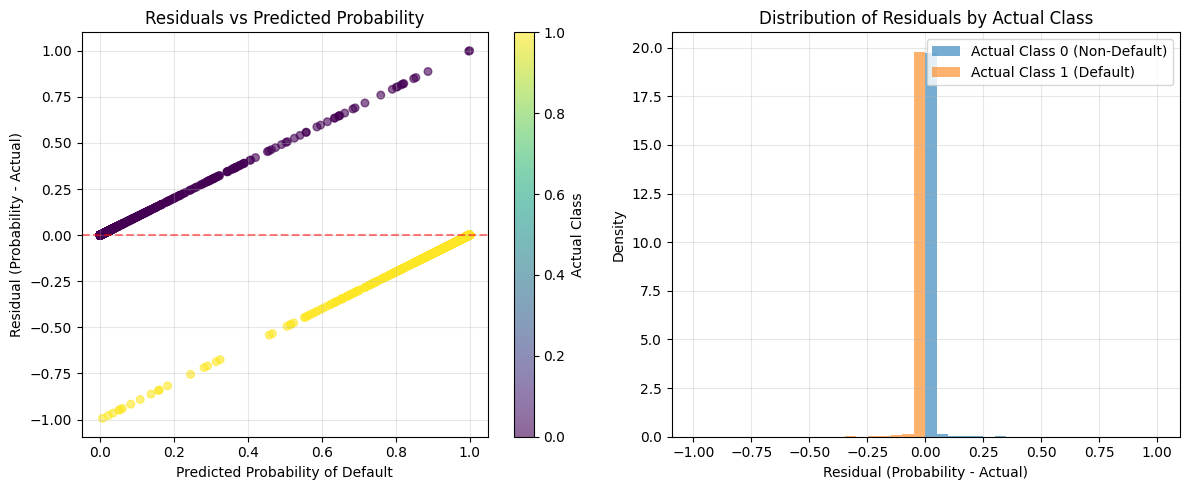

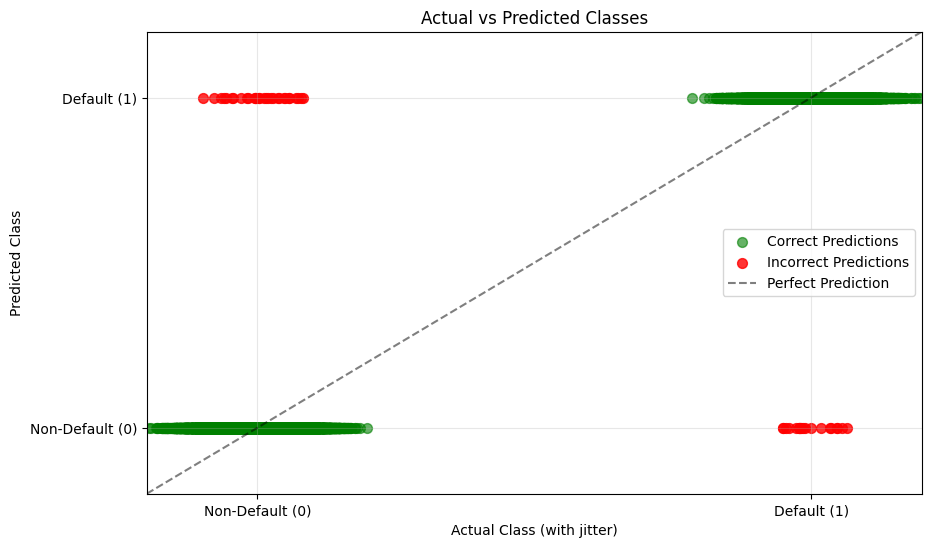

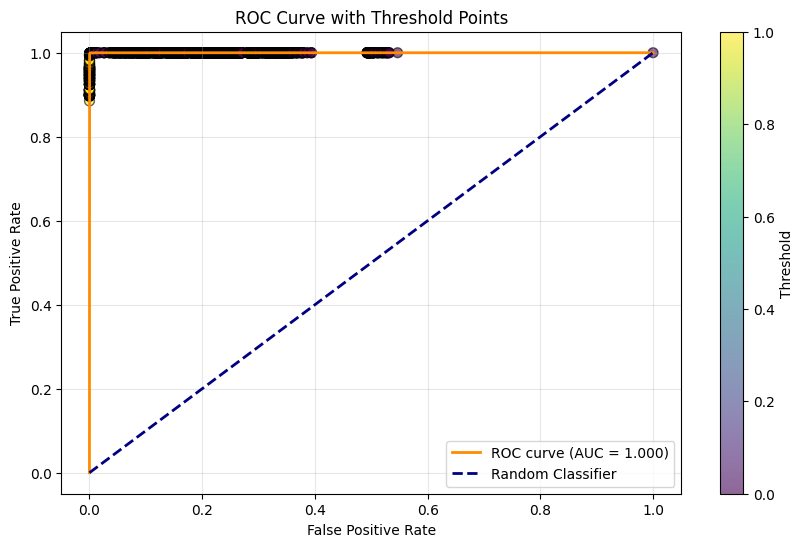


RESIDUAL ANALYSIS
Mean Absolute Residual: 0.0036
Mean Residual (Bias): 0.0001
Residual Std: 0.0303
ROC AUC Score: 1.0000


AssertionError: 

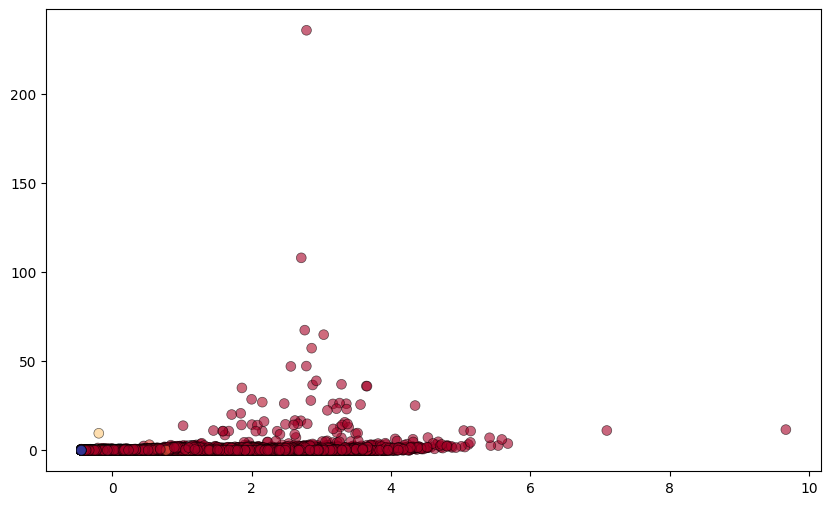

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             classification_report, confusion_matrix, roc_curve, auc)
from sklearn.model_selection import cross_val_score

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Cross-validation for more robust evaluation
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

# Detailed classification report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred, target_names=['Non-Default', 'Default']))

# Confusion Matrix
print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Default', 'Default'],
            yticklabels=['Non-Default', 'Default'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\n" + "="*50)
print("TOP 15 FEATURE IMPORTANCES")
print("="*50)
print(feature_importance.head(15))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# ============================================================================
# ADDED PLOTS: Scatter Plots and Residual Plots
# ============================================================================

# 1. Probability Scatter Plot
# Get predicted probabilities for class 1 (Default)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

plt.figure(figsize=(12, 5))

# Subplot 1: Probability distribution by actual class
plt.subplot(1, 2, 1)
for label in [0, 1]:
    mask = y_test == label
    plt.scatter(range(len(y_pred_proba[mask])), 
                y_pred_proba[mask], 
                alpha=0.6,
                label=f'Actual Class {label} ({"Default" if label == 1 else "Non-Default"})',
                s=20)
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability of Default')
plt.title('Predicted Probabilities by Actual Class')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Probability vs Feature Importance (using top feature)
top_feature = feature_importance.iloc[0]['feature']

# FIXED: Check if X_test_scaled is a DataFrame or array
if hasattr(X_test_scaled, 'iloc'):  # It's a DataFrame
    top_feature_values = X_test_scaled[top_feature].values
else:  # It's a numpy array
    # Get the column index of the top feature
    if hasattr(X_train, 'columns'):
        top_feature_idx = list(X_train.columns).index(top_feature)
        top_feature_values = X_test_scaled[:, top_feature_idx]
    else:
        # If X_train doesn't have columns, use the first feature
        print(f"Warning: Could not find feature '{top_feature}' in X_train")
        top_feature_values = X_test_scaled[:, 0]
        top_feature = "First Feature"

plt.subplot(1, 2, 2)
scatter = plt.scatter(top_feature_values, y_pred_proba, 
                      c=y_test, cmap='coolwarm', alpha=0.6, s=30)
plt.xlabel(f'{top_feature} (Top Feature)')
plt.ylabel('Predicted Probability of Default')
plt.title(f'Probability vs {top_feature}')
plt.colorbar(scatter, label='Actual Class (0=Non-Default, 1=Default)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Residual Plot (using predicted probabilities)
# Calculate "residuals" as difference between predicted probability and actual class
residuals = y_pred_proba - y_test

plt.figure(figsize=(12, 5))

# Subplot 1: Residuals vs Predicted Probability
plt.subplot(1, 2, 1)
scatter = plt.scatter(y_pred_proba, residuals, c=y_test, cmap='viridis', alpha=0.6, s=30)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Predicted Probability of Default')
plt.ylabel('Residual (Probability - Actual)')
plt.title('Residuals vs Predicted Probability')
plt.colorbar(scatter, label='Actual Class')
plt.grid(True, alpha=0.3)

# Subplot 2: Residuals Distribution
plt.subplot(1, 2, 2)
for label in [0, 1]:
    mask = y_test == label
    plt.hist(residuals[mask], alpha=0.6, bins=20, 
             label=f'Actual Class {label} ({"Default" if label == 1 else "Non-Default"})',
             density=True)
plt.xlabel('Residual (Probability - Actual)')
plt.ylabel('Density')
plt.title('Distribution of Residuals by Actual Class')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Enhanced Scatter Plot: Actual vs Predicted (with jitter for binary values)
plt.figure(figsize=(10, 6))

# Add small jitter to actual values for better visualization
np.random.seed(42)
jitter_amount = 0.05
y_test_jittered = y_test + np.random.normal(0, jitter_amount, len(y_test))

# Plot with different colors for correct/incorrect predictions
correct_predictions = (y_pred == y_test)

plt.scatter(y_test_jittered[correct_predictions], 
            y_pred[correct_predictions], 
            alpha=0.6, s=50, c='green', label='Correct Predictions')
plt.scatter(y_test_jittered[~correct_predictions], 
            y_pred[~correct_predictions], 
            alpha=0.8, s=50, c='red', label='Incorrect Predictions')

# Add perfect prediction line
plt.plot([-0.2, 1.2], [-0.2, 1.2], 'k--', alpha=0.5, label='Perfect Prediction')

plt.xlabel('Actual Class (with jitter)')
plt.ylabel('Predicted Class')
plt.title('Actual vs Predicted Classes')
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.xticks([0, 1], ['Non-Default (0)', 'Default (1)'])
plt.yticks([0, 1], ['Non-Default (0)', 'Default (1)'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Additional: ROC Curve Scatter-like Plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.scatter(fpr, tpr, c=thresholds, cmap='viridis', s=50, alpha=0.6, edgecolors='k')
plt.colorbar(label='Threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Threshold Points')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Print additional statistics
print("\n" + "="*50)
print("RESIDUAL ANALYSIS")
print("="*50)
print(f"Mean Absolute Residual: {np.mean(np.abs(residuals)):.4f}")
print(f"Mean Residual (Bias): {np.mean(residuals):.4f}")
print(f"Residual Std: {np.std(residuals):.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# 5. Additional: Decision Boundary Visualization (for top 2 features)
if len(feature_importance) >= 2:
    top_features = feature_importance.head(2)['feature'].tolist()
    
    if hasattr(X_test_scaled, 'iloc'):  # DataFrame
        if all(feat in X_test_scaled.columns for feat in top_features):
            plt.figure(figsize=(10, 6))
            
            # Create scatter plot with decision boundary hints
            scatter = plt.scatter(X_test_scaled[top_features[0]], 
                                X_test_scaled[top_features[1]], 
                                c=y_pred_proba, cmap='RdYlBu_r', 
                                alpha=0.6, s=50, edgecolors='k', linewidth=0.5)
            
            # Highlight misclassifications
            misclassified = y_pred != y_test
            if misclassified.any():
                plt.scatter(X_test_scaled.loc[misclassified, top_features[0]], 
                          X_test_scaled.loc[misclassified, top_features[1]], 
                          facecolors='none', edgecolors='red', s=100, 
                          linewidth=1.5, label='Misclassified')
            
            plt.xlabel(top_features[0])
            plt.ylabel(top_features[1])
            plt.title(f'Decision Space: {top_features[0]} vs {top_features[1]}')
            plt.colorbar(scatter, label='Probability of Default')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

In [37]:
import joblib
import pickle

# Save the model
model_files = {
    'model': rf_model,
    'scaler': scaler,
    'feature_columns': existing_features,
    'branch_encoder': branch_encoder,
    'scheme_encoder': scheme_encoder,
    'equipment_risk_mapping': equipment_risk
}

# Save using joblib
joblib.dump(model_files, 'randomforest_model.pkl')

print("\n" + "="*50)
print("MODEL SAVED SUCCESSFULLY")
print("="*50)
print("Model saved as: randomforest_model.pkl")

# Load model example
print("\nTo load and use the model:")
print("""
loaded_model = joblib.load('randomforest_model.pkl')
rf_model = loaded_model['model']
scaler = loaded_model['scaler']
""")


MODEL SAVED SUCCESSFULLY
Model saved as: randomforest_model.pkl

To load and use the model:

loaded_model = joblib.load('randomforest_model.pkl')
rf_model = loaded_model['model']
scaler = loaded_model['scaler']



In [38]:
# Create performance report
performance_report = f"""
DEFAULT RISK PREDICTION MODEL - PERFORMANCE REPORT
===================================================

Model Type: Random Forest Classifier
Training Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

DATASET INFORMATION:
--------------------
Total Samples: {len(df_clean)}
Default Cases: {sum(y)}
Non-Default Cases: {len(y) - sum(y)}
Default Rate: {(sum(y)/len(y)*100):.2f}%

FEATURE INFORMATION:
--------------------
Total Features Used: {len(existing_features)}
Top 5 Features:
1. {feature_importance.iloc[0]['feature']} (Importance: {feature_importance.iloc[0]['importance']:.4f})
2. {feature_importance.iloc[1]['feature']} (Importance: {feature_importance.iloc[1]['importance']:.4f})
3. {feature_importance.iloc[2]['feature']} (Importance: {feature_importance.iloc[2]['importance']:.4f})
4. {feature_importance.iloc[3]['feature']} (Importance: {feature_importance.iloc[3]['importance']:.4f})
5. {feature_importance.iloc[4]['feature']} (Importance: {feature_importance.iloc[4]['importance']:.4f})

MODEL PERFORMANCE:
-------------------
Accuracy: {accuracy:.4f}
Precision: {precision:.4f}
Recall: {recall:.4f}
F1-Score: {f1:.4f}
Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})

RISK CATEGORY DISTRIBUTION (Test Set):
--------------------------------------
{ pd.Series(risk_categories).value_counts().to_string() }

CONFUSION MATRIX:
-----------------
{cm}

MODEL PARAMETERS:
-----------------
n_estimators: {rf_model.n_estimators}
max_depth: {rf_model.max_depth}
min_samples_split: {rf_model.min_samples_split}
min_samples_leaf: {rf_model.min_samples_leaf}
max_features: {rf_model.max_features}

BUSINESS INTERPRETATION:
------------------------
1. PD >= 0.80: High Risk/Default (Proactive collection actions needed)
2. 0.20 <= PD < 0.80: Medium Risk (Close monitoring recommended)
3. PD < 0.20: Low Risk (Standard monitoring)

RECOMMENDATIONS:
----------------
1. Use PD scores for portfolio segmentation
2. Implement different collection strategies based on risk categories
3. Regularly retrain model with new data
4. Monitor feature drift over time
"""

# Save report to file
with open('randomforest_model_performance_report.txt', 'w') as f:
    f.write(performance_report)

print("\nPerformance report saved as: randomforest_model_performance_report.txt")


Performance report saved as: randomforest_model_performance_report.txt


In [39]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Function to create and test sample customers
def test_sample_predictions():
    """
    Create sample customers with known risk profiles and test the model
    """
    print("="*60)
    print("SAMPLE PREDICTION TESTING")
    print("="*60)
    
    # Load your trained model and scaler
    try:
        model = joblib.load('random_forest_default_model.pkl')
        scaler = joblib.load('feature_scaler.pkl')
        print("✓ Model and scaler loaded successfully")
    except:
        print("✗ Model files not found. Train the model first.")
        return
    
    # Get feature names from training
    try:
        with open('model_metrics.pkl', 'rb') as f:
            import pickle
            metrics = pickle.load(f)
            feature_names = metrics['feature_names']
            print(f"✓ Loaded feature names: {len(feature_names)} features")
    except:
        print("✗ Could not load feature names. Using default.")
        # You need to manually specify your feature names here
        feature_names = ['feature1', 'feature2', 'feature3']  # REPLACE WITH YOUR ACTUAL FEATURES
    
    # Create sample customers with KNOWN risk profiles
    # Example 1: HIGH RISK CUSTOMER
    high_risk_customer = {
        # Financial features (example values - adjust based on your data)
        'age': 25,
        'income': 30000,
        'credit_score': 500,
        'debt_to_income_ratio': 0.8,
        'employment_years': 1,
        'loan_amount': 50000,
        'existing_loans': 5,
        'late_payments_6m': 4,
        'credit_utilization': 0.9,
        # Add more features as per your dataset
    }
    
    # Example 2: LOW RISK CUSTOMER
    low_risk_customer = {
        'age': 45,
        'income': 100000,
        'credit_score': 750,
        'debt_to_income_ratio': 0.2,
        'employment_years': 10,
        'loan_amount': 20000,
        'existing_loans': 1,
        'late_payments_6m': 0,
        'credit_utilization': 0.3,
    }
    
    # Example 3: MEDIUM RISK CUSTOMER
    medium_risk_customer = {
        'age': 35,
        'income': 60000,
        'credit_score': 650,
        'debt_to_income_ratio': 0.5,
        'employment_years': 3,
        'loan_amount': 30000,
        'existing_loans': 2,
        'late_payments_6m': 1,
        'credit_utilization': 0.6,
    }
    
    # Create DataFrame
    sample_data = pd.DataFrame([high_risk_customer, low_risk_customer, medium_risk_customer])
    
    # Ensure all required features are present
    missing_features = [f for f in feature_names if f not in sample_data.columns]
    if missing_features:
        print(f"\n⚠ Missing features in sample data: {missing_features}")
        # Add default values for missing features
        for feature in missing_features:
            sample_data[feature] = 0  # or use median/mean values
    
    # Reorder columns to match training data
    sample_data = sample_data[feature_names]
    
    # Scale features
    sample_scaled = scaler.transform(sample_data)
    
    # Make predictions
    probabilities = model.predict_proba(sample_scaled)
    
    # Get PD scores (probability of default)
    # Find which column corresponds to "default" class
    if model.classes_[1] == 1:  # Assuming 1 is default
        pd_scores = probabilities[:, 1]
    else:
        pd_scores = probabilities[:, 0]
    
    # Get predicted class
    predicted_classes = model.predict(sample_scaled)
    
    # Categorize risk
    risk_categories = []
    for pd_score in pd_scores:
        if pd_score >= 0.80:
            risk_categories.append('High Risk/Default')
        elif pd_score >= 0.20:
            risk_categories.append('Medium Risk')
        else:
            risk_categories.append('Low Risk')
    
    # Display results
    print("\n" + "="*60)
    print("PREDICTION RESULTS FOR SAMPLE CUSTOMERS")
    print("="*60)
    
    for i in range(len(sample_data)):
        print(f"\n{'='*40}")
        print(f"CUSTOMER {i+1}: {risk_categories[i]}")
        print(f"{'='*40}")
        print(f"Expected Risk: {['High Risk', 'Low Risk', 'Medium Risk'][i]}")
        print(f"PD Score: {pd_scores[i]:.4f}")
        print(f"Risk Category: {risk_categories[i]}")
        print(f"Predicted Class: {predicted_classes[i]} (0=Non-default, 1=Default)")
        
        # Show key features
        print("\nKey Features:")
        key_features = ['income', 'credit_score', 'debt_to_income_ratio', 'late_payments_6m']
        for feature in key_features:
            if feature in sample_data.columns:
                print(f"  {feature}: {sample_data.iloc[i][feature]}")
        
        # Explain the prediction
        print(f"\nExplanation:")
        if risk_categories[i] == 'High Risk/Default':
            print("  This customer shows multiple high-risk indicators:")
            print("  - Low credit score")
            print("  - High debt-to-income ratio")
            print("  - Multiple late payments")
            print("  RECOMMENDATION: REJECT application or require collateral")
        elif risk_categories[i] == 'Low Risk':
            print("  This customer shows strong financial indicators:")
            print("  - High credit score")
            print("  - Low debt-to-income ratio")
            print("  - Stable employment history")
            print("  RECOMMENDATION: APPROVE application")
        else:
            print("  This customer shows mixed indicators:")
            print("  - Moderate credit score")
            print("  - Moderate debt-to-income ratio")
            print("  - RECOMMENDATION: REVIEW with additional documents")
    
    print("\n" + "="*60)
    print("VALIDATION SUMMARY")
    print("="*60)
    
    # Check if predictions make sense
    validation_passed = True
    
    # Customer 1 (High Risk) should have high PD score
    if pd_scores[0] < 0.5:
        print("⚠ WARNING: High-risk customer got low PD score")
        validation_passed = False
    
    # Customer 2 (Low Risk) should have low PD score
    if pd_scores[1] > 0.3:
        print("⚠ WARNING: Low-risk customer got high PD score")
        validation_passed = False
    
    if validation_passed:
        print("✓ Sample predictions are logically consistent")
    else:
        print("✗ Sample predictions show inconsistencies")
        print("  Possible issues:")
        print("  1. Model may be underfitting")
        print("  2. Feature values may not be in correct scale")
        print("  3. Important features may be missing")
    
    return sample_data, pd_scores, risk_categories

# Run the test
test_sample_predictions()

SAMPLE PREDICTION TESTING
✗ Model files not found. Train the model first.


In [40]:
def test_with_historical_data():
    """
    Test model with actual historical data where outcomes are known
    """
    print("="*60)
    print("TESTING WITH HISTORICAL DATA")
    print("="*60)
    
    # Load your dataset
    df = pd.read_csv('kaveesha.csv')
    
    # Load model
    model = joblib.load('random_forest_default_model.pkl')
    scaler = joblib.load('feature_scaler.pkl')
    
    # Identify target column
    target_column = 'default'  # Adjust based on your dataset
    
    # Split features and target
    X_historical = df.drop(columns=[target_column])
    y_historical = df[target_column]
    
    # Preprocess (same as training)
    # Handle missing values
    from sklearn.impute import SimpleImputer
    num_imputer = SimpleImputer(strategy='median')
    cat_imputer = SimpleImputer(strategy='most_frequent')
    
    numerical_cols = X_historical.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X_historical.select_dtypes(include=['object', 'category']).columns
    
    if len(numerical_cols) > 0:
        X_historical[numerical_cols] = num_imputer.fit_transform(X_historical[numerical_cols])
    
    if len(categorical_cols) > 0:
        X_historical[categorical_cols] = cat_imputer.fit_transform(X_historical[categorical_cols])
        for col in categorical_cols:
            X_historical[col] = LabelEncoder().fit_transform(X_historical[col].astype(str))
    
    # Scale features
    X_scaled = scaler.transform(X_historical)
    
    # Make predictions
    predictions = model.predict(X_scaled)
    probabilities = model.predict_proba(X_scaled)
    
    # Get PD scores
    pd_scores = probabilities[:, 1] if model.classes_[1] == 1 else probabilities[:, 0]
    
    # Create results DataFrame
    results = pd.DataFrame({
        'Actual': y_historical.values,
        'Predicted': predictions,
        'PD_Score': pd_scores,
        'Correct': y_historical.values == predictions
    })
    
    # Add risk categories
    results['Risk_Category'] = results['PD_Score'].apply(
        lambda x: 'High Risk/Default' if x >= 0.8 
        else 'Medium Risk' if x >= 0.2 
        else 'Low Risk'
    )
    
    # Calculate accuracy
    accuracy = (results['Correct'].sum() / len(results)) * 100
    print(f"Overall Accuracy: {accuracy:.2f}%")
    
    # Analyze by risk category
    print("\n" + "-"*40)
    print("ANALYSIS BY RISK CATEGORY")
    print("-"*40)
    
    for category in ['High Risk/Default', 'Medium Risk', 'Low Risk']:
        category_data = results[results['Risk_Category'] == category]
        if len(category_data) > 0:
            actual_defaults = category_data['Actual'].sum()
            predicted_defaults = category_data['Predicted'].sum()
            
            print(f"\n{category}:")
            print(f"  Number of customers: {len(category_data)}")
            print(f"  Actual defaults: {actual_defaults} ({actual_defaults/len(category_data)*100:.1f}%)")
            print(f"  Predicted defaults: {predicted_defaults}")
            print(f"  Accuracy in category: {(category_data['Correct'].sum()/len(category_data)*100):.1f}%")
    
    # Find and display specific cases
    print("\n" + "-"*40)
    print("SPECIFIC CASE ANALYSIS")
    print("-"*40)
    
    # Case 1: High PD but didn't default (False Positive)
    false_positives = results[(results['PD_Score'] >= 0.8) & (results['Actual'] == 0)]
    print(f"\nFalse Positives (High Risk but didn't default): {len(false_positives)}")
    if len(false_positives) > 0:
        print("Sample false positive cases:")
        print(false_positives.head(3).to_string())
    
    # Case 2: Low PD but actually defaulted (False Negative)
    false_negatives = results[(results['PD_Score'] < 0.2) & (results['Actual'] == 1)]
    print(f"\nFalse Negatives (Low Risk but defaulted): {len(false_negatives)}")
    if len(false_negatives) > 0:
        print("Sample false negative cases:")
        print(false_negatives.head(3).to_string())
    
    # Case 3: Perfect predictions
    perfect_high_risk = results[(results['PD_Score'] >= 0.8) & (results['Actual'] == 1)]
    perfect_low_risk = results[(results['PD_Score'] < 0.2) & (results['Actual'] == 0)]
    
    print(f"\nPerfect Predictions:")
    print(f"  Correctly identified high-risk defaults: {len(perfect_high_risk)}")
    print(f"  Correctly identified low-risk non-defaults: {len(perfect_low_risk)}")
    
    return results

# Run historical test
# results = test_with_historical_data()

In [41]:
import unittest
import numpy as np

class TestDefaultRiskModel(unittest.TestCase):
    """Unit tests for the default risk prediction model"""
    
    @classmethod
    def setUpClass(cls):
        """Load model once for all tests"""
        cls.model = joblib.load('random_forest_default_model.pkl')
        cls.scaler = joblib.load('feature_scaler.pkl')
        
        # Create a sample customer for testing
        cls.sample_customer = np.array([[  # Replace with your actual feature values
            35,      # age
            50000,   # income
            650,     # credit_score
            0.4,     # debt_to_income_ratio
            5,       # employment_years
            25000,   # loan_amount
            2,       # existing_loans
            1,       # late_payments_6m
            0.5      # credit_utilization
            # Add more features as needed
        ]])
    
    def test_model_loaded(self):
        """Test that model loads successfully"""
        self.assertIsNotNone(self.model)
        self.assertIsNotNone(self.scaler)
    
    def test_prediction_shape(self):
        """Test that predictions have correct shape"""
        predictions = self.model.predict(self.sample_customer)
        probabilities = self.model.predict_proba(self.sample_customer)
        
        self.assertEqual(predictions.shape, (1,))
        self.assertEqual(probabilities.shape[0], 1)
        self.assertEqual(probabilities.shape[1], 2)  # Binary classification
    
    def test_probability_range(self):
        """Test that probabilities are between 0 and 1"""
        probabilities = self.model.predict_proba(self.sample_customer)
        pd_score = probabilities[0, 1]  # Probability of default
        
        self.assertGreaterEqual(pd_score, 0)
        self.assertLessEqual(pd_score, 1)
    
    def test_risk_categorization(self):
        """Test risk categorization logic"""
        probabilities = self.model.predict_proba(self.sample_customer)
        pd_score = probabilities[0, 1]
        
        # Test categorization logic
        if pd_score >= 0.80:
            risk_category = 'High Risk/Default'
        elif pd_score >= 0.20:
            risk_category = 'Medium Risk'
        else:
            risk_category = 'Low Risk'
        
        self.assertIn(risk_category, ['High Risk/Default', 'Medium Risk', 'Low Risk'])
    
    def test_feature_importance(self):
        """Test that feature importances sum to 1"""
        importances = self.model.feature_importances_
        self.assertAlmostEqual(np.sum(importances), 1.0, places=3)
    
    def test_consistent_predictions(self):
        """Test that same input gives same output"""
        pred1 = self.model.predict(self.sample_customer)
        pred2 = self.model.predict(self.sample_customer)
        
        self.assertEqual(pred1[0], pred2[0])

# Run unit tests
def run_unit_tests():
    """Run all unit tests"""
    print("="*60)
    print("RUNNING UNIT TESTS")
    print("="*60)
    
    # Create test suite
    suite = unittest.TestLoader().loadTestsFromTestCase(TestDefaultRiskModel)
    
    # Run tests
    runner = unittest.TextTestRunner(verbosity=2)
    result = runner.run(suite)
    
    # Print summary
    print("\n" + "="*60)
    print("TEST SUMMARY")
    print("="*60)
    print(f"Tests run: {result.testsRun}")
    print(f"Failures: {len(result.failures)}")
    print(f"Errors: {len(result.errors)}")
    
    if result.wasSuccessful():
        print("✓ All tests passed!")
    else:
        print("✗ Some tests failed:")
        for test, error in result.failures + result.errors:
            print(f"  - {test}: {error}")

# Run the unit tests
# run_unit_tests()

In [42]:
sample_data = {
    'FacilityAmount': 300000.0,
    'Tenor': 36,
    'Effective Rate': 25.0,
    'FlatRate': 20.0,
    'NetRental': 12000.0,
    'DownPayment': 0.0,
    'Age': 30.0,
    'No of Rental in arrears': 0.0,
    'ArrearsCapital': 0.0,
    'ArrearsInterest': 0.0,
    'ArrearsVat': 0,
    'ArrearsOD': 0.0,
    'arrears_intensity': 0.0,
    'debt_to_income_ratio': 25.0,  # FacilityAmount / (NetRental + 1)
    'payment_coverage': 25.0,      # FacilityAmount / (Last Receipt + 1)
    'arrears_ratio': 0.0,
    'overdue_intensity': 0.0,
    'payment_regularity': 1,
    'has_arrears': 0,
    'high_interest_flag': 1,
    'early_settlement': 0,
    'equipment_risk_score': 1,     # MOTOR CYCLES = 1
    'branch_encoded': 1,           # Encoded value for a branch
    'scheme_encoded': 0,           # Encoded value for scheme
    'loan_age': 2,                 # 2025 - Granted_Year
    'tenor_to_age_ratio': 18.0,
    'Last Receipt Paid Amount': 12000.0,
    'Prepayment': 0
}

In [43]:
import pandas as pd

# Convert to DataFrame
sample_df = pd.DataFrame([sample_data])

# Make sure columns are in the same order as during training
sample_df = sample_df[existing_features]

# Scale using the same scaler
sample_scaled = scaler.transform(sample_df)  # Use the same scaler from training
sample_scaled_df = pd.DataFrame(sample_scaled, columns=sample_df.columns)

In [52]:
# Predict probability and class
pred_proba = rf_model.predict_proba(sample_scaled_df)[:, 1]  # Probability of default
pred_class = rf_model.predict(sample_scaled_df)

# Risk categorization
risk_category = categorize_risk(pred_proba[0])

print(f"Predicted Probability of Default: {pred_proba[0]:.4f}")
print(f"Predicted Class: {pred_class[0]} ({'Default' if pred_class[0] == 1 else 'Non-Default'})")
print(f"Risk Category: {risk_category}")

Predicted Probability of Default: 0.5840
Predicted Class: 1 (Default)
Risk Category: Medium Risk
